# Lab 7.06 - Time series analysis

In [1]:
# Package imports
import numpy as np                                  # "Scientific computing"
import pandas as pd                                 # Dataframe
import scipy.stats as stats                         # Statistical tests

import matplotlib.pyplot as plt                     # Basic visualisation
import seaborn as sns                               # Advanced dataviz

from sklearn.linear_model import LinearRegression   # Linear regression model

# Time series analysis
from datetime import datetime
from sklearn.metrics import mean_absolute_error,mean_squared_error
from statsmodels.tsa.api import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose

## Exercise 6: COVID-19 data


In this lab assignment, we will make use of the COVID-19 dataset maintained by [Our World in Data](https://ourworldindata.org/coronavirus), published on Github at <https://github.com/owid/covid-19-data/tree/master/public/data>.

We took a snapshot of the data on 2023-05-31 that still contains *daily* observations. Recently, the dataset has been updated to only contain weekly observations.

First, we import the dataset, parse the `date` column as the Python `DateTime` type and set this as the index.

**Tip:** The CSV file is rather large, so instead you may want to load a local copy of the CSV file to avoid downloading it multiple times ('../data/owid-covid-data-2023-05-31.csv').

In [2]:
covid19 = pd.read_csv(
    'https://github.com/HoGentTIN/dsai-labs/raw/main/data/owid-covid-data-2023-05-31.csv',
    parse_dates=['date'],
    index_col=['date'])
covid19.head()

,iso_code,continent,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
date,,,,,,,,,,,,,,,,,,,,,
2020-01-03,AFG,Asia,Afghanistan,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2020-01-04,AFG,Asia,Afghanistan,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2020-01-05,AFG,Asia,Afghanistan,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2020-01-06,AFG,Asia,Afghanistan,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2020-01-07,AFG,Asia,Afghanistan,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN


Create a new `DataFrame` (with name e.g. `covid19_be`) that only contains the new cases in Belgium and use the `plot()` method of `DataFrame` to visualize it. Increase the size of the picture with the `figsize` parameter, otherwise it will be too small.

Text(0.5, 0, 'Date')

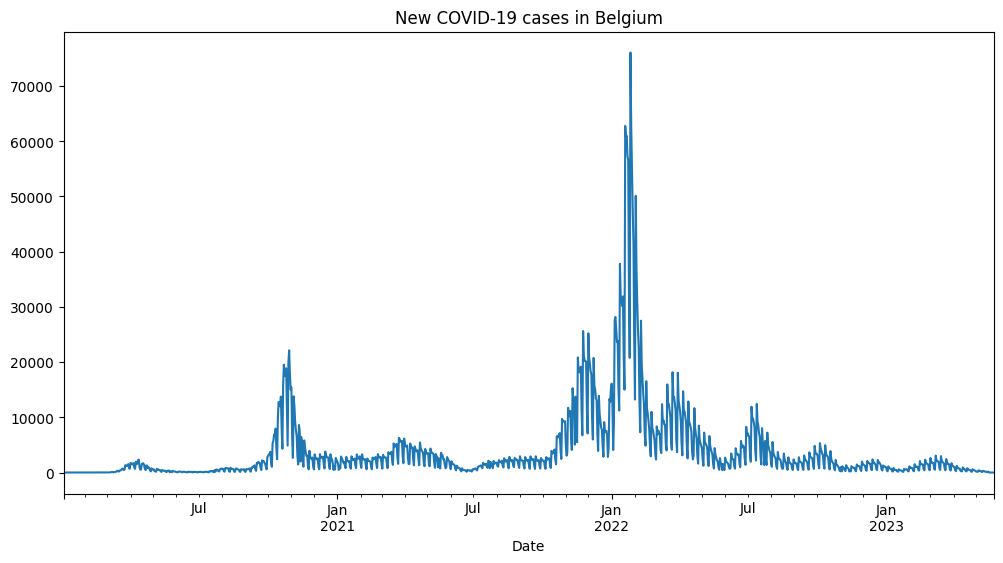

In [7]:
# new cases in belgium
covid19_be = covid19[covid19['location'] == 'Belgium']['new_cases']
covid19_be = covid19_be.dropna()  # remove NaN values
# use plot of DataFrame to visualise, use figsize to set the size of the figure
covid19_be.plot(figsize=(12, 6), title='New COVID-19 cases in Belgium')
plt.xlabel('Date')

### Moving average

Add new columns to the data frame with new cases in Belgium with the simple moving average for 7 and 30 days. Plot the entire data frame (observations and both moving averages).

Text(0.5, 0, 'Date')

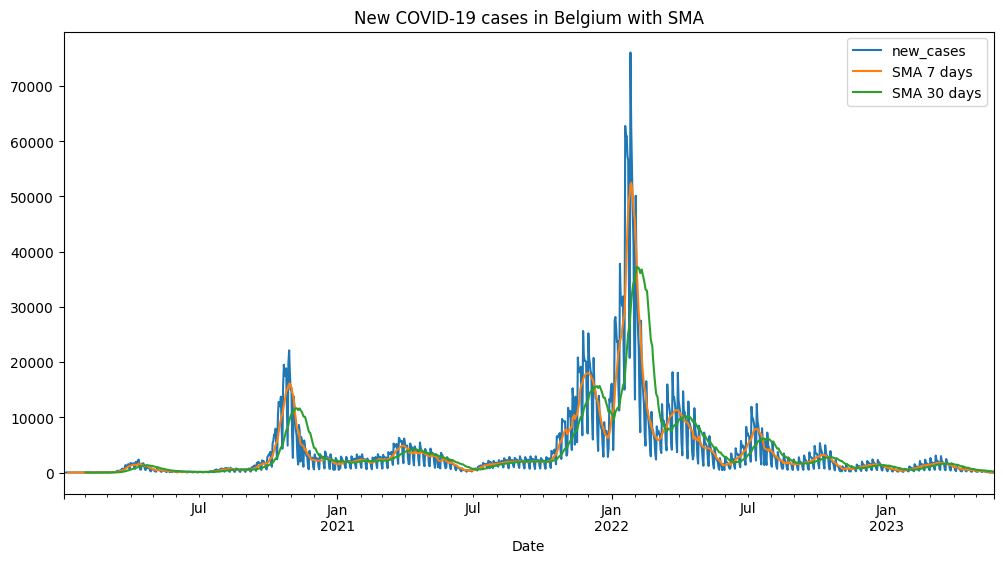

In [8]:
# Add new columns to the data frame with new cases in Belgium with the simple moving average for 7 and 30 days. Plot the entire data frame (observations and both moving averages).
covid19_be_sma7 = covid19_be.rolling(window=7).mean()
covid19_be_sma30 = covid19_be.rolling(window=30).mean()
covid19_be_sma7.name = 'SMA 7 days'
covid19_be_sma30.name = 'SMA 30 days'
covid19_be = pd.concat([covid19_be, covid19_be_sma7, covid19_be_sma30], axis=1)
covid19_be.plot(figsize=(12, 6), title='New COVID-19 cases in Belgium with SMA')
plt.xlabel('Date')



### Holt-Winters model for new cases early 2021

The period from about December 2020 up to the end of February 2021 seems quite regular. Create a new `DataFrame` and select only the observations during that period (1 December 2020 to 28 February 2021). Plot the `DataFrame` (it will still contain the moving averages from the previous step).

Text(0.5, 0, 'Date')

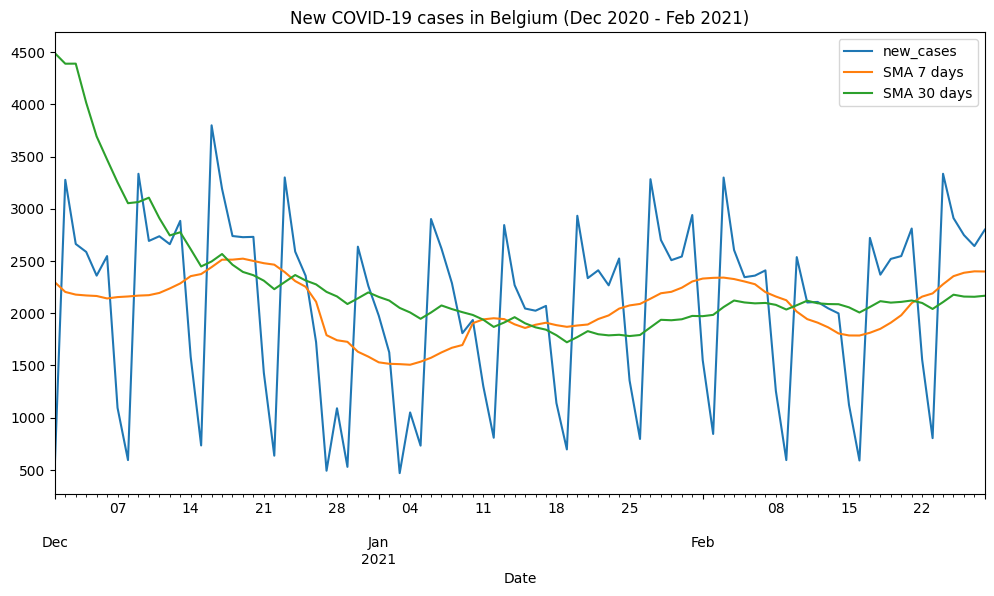

In [9]:
# The period from about December 2020 up to the end of February 2021 seems quite regular. Create a new `DataFrame` and select only the observations during that period (1 December 2020 to 28 February 2021). Plot the `DataFrame` (it will still contain the moving averages from the previous step).
covid19_be_dec2020_feb2021 = covid19_be['2020-12-01':'2021-02-28']
covid19_be_dec2020_feb2021.plot(figsize=(12, 6), title='New COVID-19 cases in Belgium (Dec 2020 - Feb 2021)')
plt.xlabel('Date')



Build a Holt-Winters model for the observed new cases during that period.

Use the additive type for both trend and seasonal smoothing. Set the value for `seasonal_periods` to the appropriate value! Plot the observed and fitted values.

c:\Users\Gebruiker\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


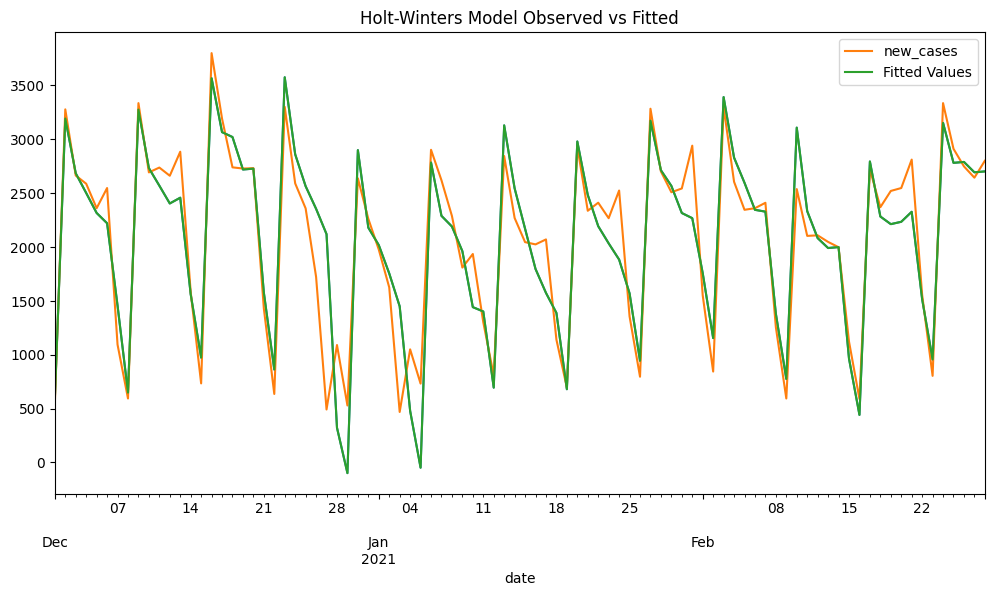

In [15]:
holt_winters_model = ExponentialSmoothing(
    covid19_be_dec2020_feb2021.iloc[:, 0],  # Only the first column (new cases)
    trend='add',
    seasonal='add',
    seasonal_periods=7
).fit()

holt_winters_model.fittedvalues.plot(figsize=(12, 6), title='Holt-Winters Model Fitted Values')
covid19_be_dec2020_feb2021.iloc[:, 0].plot(figsize=(12, 6), title='Holt-Winters Model Observed vs Fitted')
plt.xlabel('Date')
holt_winters_model.fittedvalues.name = 'Fitted Values'
holt_winters_model.fittedvalues.plot(label='Fitted Values')
plt.legend()

Now, make a forecast for 21 days and plot observed and forecasted values. What do you notice when you compare observed and forecasted values as time progresses?

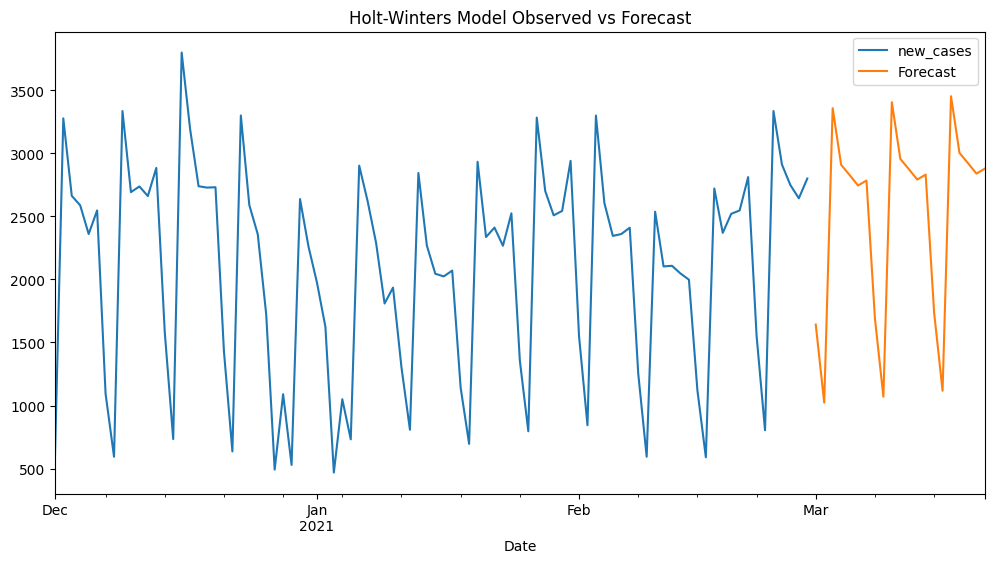

In [16]:
# Now, make a forecast for 21 days and plot observed and forecasted values. What do you notice when you compare observed and forecasted values as time progresses?
forecast = holt_winters_model.forecast(21)
forecast.name = 'Forecast'
covid19_be_dec2020_feb2021.iloc[:, 0].plot(figsize=(12, 6), title='Holt-Winters Model Observed vs Forecast')
forecast.plot(label='Forecast')
plt.xlabel('Date')
plt.legend()

### Evaluating model quality


- Calculate the Mean Squared Error for a forecast period of 7 days, and compare its square root with the standard deviation of observed new cases over the test period and forecasted period combined.
- Do the same for a forecast period of 14 and 21 days.
- For which period is the quality of the forecast ok?

The expected results are shown in the table below:

|     Forecast period      |         MSE |     √MSE |    stdev |
| :----------------------: | ----------: | -------: | -------: |
| 2021-03-01 to 2021-03-07 |   25408.902 |  159.402 |  855.684 |
| 2021-03-01 to 2021-03-14 |  154280.817 |  392.786 |  895.531 |
| 2021-03-01 to 2021-03-21 | 1048835.781 | 1024.127 | 1052.978 |

In [19]:
#  Calculate the Mean Squared Error for a forecast period of 7 days, and compare its square root with the standard deviation of observed new cases over the test period and forecasted period combined.
mse_7_days = mean_squared_error(
    covid19_be_dec2020_feb2021.iloc[-7:, 0],
    forecast.iloc[:7]
)
rmse_7_days = np.sqrt(mse_7_days)
std_dev_observed = covid19_be_dec2020_feb2021.iloc[:, 0].std()
std_dev_forecasted = forecast.std()
print(f'RMSE for 7 days forecast: {rmse_7_days}')
print(f'Standard deviation of observed new cases: {std_dev_observed}')
print(f'Standard deviation of forecasted new cases: {std_dev_forecasted}')

#  - Do the same for a forecast period of 14 and 21 days.
mse_14_days = mean_squared_error(
    covid19_be_dec2020_feb2021.iloc[-14:, 0],
    forecast.iloc[:14]
)
rmse_14_days = np.sqrt(mse_14_days)
std_dev_14_days = covid19_be_dec2020_feb2021.iloc[-14:, 0].std()
print(f'RMSE for 14 days forecast: {rmse_14_days}')
print(f'Standard deviation of observed new cases for 14 days: {std_dev_14_days}')
print(f'Standard deviation of forecasted new cases for 14 days: {forecast.iloc[:14].std()}')


# - For which period is the quality of the forecast ok?
if rmse_7_days < std_dev_observed and rmse_7_days < std_dev_forecasted:
    print("The quality of the forecast for 7 days is OK.")
else:
    print("The quality of the forecast for 7 days is NOT OK.")
if rmse_14_days < std_dev_14_days and rmse_14_days < forecast.iloc[:14].std():
    print("The quality of the forecast for 14 days is OK.")
else:
    print("The quality of the forecast for 14 days is NOT OK.")




RMSE for 7 days forecast: 102.04405440754539
Standard deviation of observed new cases: 855.3982752136294
Standard deviation of forecasted new cases: 781.7233652218551
RMSE for 14 days forecast: 318.9729354985379
Standard deviation of observed new cases for 14 days: 860.8052963601922
Standard deviation of forecasted new cases for 14 days: 791.0512929508219
The quality of the forecast for 7 days is OK.
The quality of the forecast for 14 days is OK.


### ICU patients

Create a new `DataFrame` with only the total number of ICU (intensive care units) patients in the Belgian hospitals. Make sure that all NaN's are removed, since time series analysis functions can't cope with missing values. Plot this time series. 

Text(0.5, 0, 'Date')

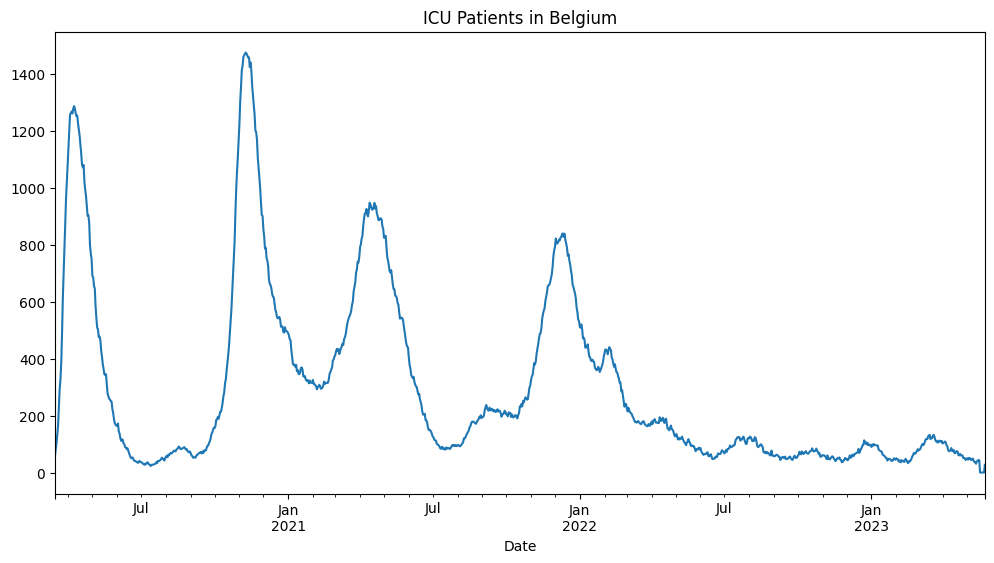

In [20]:
# ### ICU patients

# Create a new `DataFrame` with only the total number of ICU (intensive care units) patients in the Belgian hospitals. Make sure that all NaN's are removed, since time series analysis functions can't cope with missing values. Plot this time series. 

covid19_be_icu = covid19[covid19['location'] == 'Belgium']['icu_patients']
covid19_be_icu = covid19_be_icu.dropna()  # remove NaN values
covid19_be_icu.plot(figsize=(12, 6), title='ICU Patients in Belgium')
plt.xlabel('Date')


Build a duible exponential smoothing (Holt) model of this time series. Make a forecast of 70 time units and plot the observations, fitted values and forecast.

Are we currently in an upward or downward trend, according to this model? Do the forecasted values seem reasonable if you look at the last period?

c:\Users\Gebruiker\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


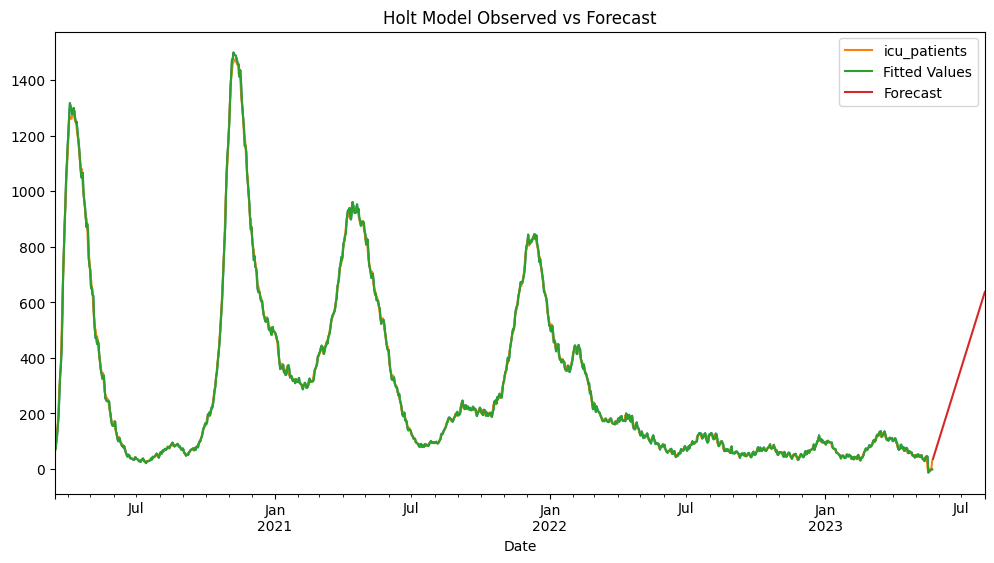

In [ ]:
# Build a duible exponential smoothing (Holt) model of this time series. Make a forecast of 70 time units and plot the observations, fitted values and forecast.

# Are we currently in an upward or downward trend, according to this model? Do the forecasted values seem reasonable if you look at the last period?

holt_model = Holt(covid19_be_icu).fit()
holt_model.fittedvalues.plot(figsize=(12, 6), title='Holt Model Fitted Values')
forecast_icu = holt_model.forecast(70)
forecast_icu.name = 'Forecast'
covid19_be_icu.plot(figsize=(12, 6), title='Holt Model Observed vs Forecast')
holt_model.fittedvalues.plot(label='Fitted Values')
forecast_icu.plot(label='Forecast')
plt.xlabel('Date')
plt.legend()
# The trend is currently upward, as the fitted values are increasing. The forecasted values also seem reasonable, as they follow the trend of the last period.


Since we didn't set any initial parameters like $\alpha$ and $\beta$, the model calculated them using some rule of thumb. List these parameters from the model:

In [27]:
# Since we didn't set any initial parameters like $\alpha$ and $\beta$, the model calculated them using some rule of thumb. List these parameters from the model:
# 
# {'smoothing_level': 0.95846630905084, 'smoothing_trend': 0.37302331730761334, 'smoothing_seasonal': nan, 'damping_trend': nan, 'initial_level': 53.0, 'initial_trend': 26.0, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}
print(f"Alpha (level smoothing): {holt_model.params['smoothing_level']}")
print(f"Beta (trend smoothing): {holt_model.params['smoothing_trend']}")



Alpha (level smoothing): 0.95846630905084
Beta (trend smoothing): 0.37302331730761334


What were the final estimated values for the level and trend, that are used in the forecast? In other words, what are the parameters of the line that estimates future observations?

In [28]:
# What were the final estimated values for the level and trend, that are used in the forecast? In other words, what are the parameters of the line that estimates future observations?
final_level = holt_model.params['initial_level'] + (holt_model.params['smoothing_level'] * (holt_model.fittedvalues.iloc[-1] - holt_model.params['initial_level']))
final_trend = holt_model.params['initial_trend'] + (holt_model.params['smoothing_trend'] * (holt_model.fittedvalues.iloc[-1] - holt_model.params['initial_trend']))
print(f"Final Level: {final_level}")
print(f"Final Trend: {final_trend}")
# The final level and trend are the last fitted values of the model, which represent the estimated level and trend at the end of the observed period. They are used to project future values in the forecast.

Final Level: 0.6650028249350157
Final Trend: 15.70349135193111


Let's try to set the parameters ourselves. Recreate the Holt-model with $\alpha = \beta = 0.1$. Calculate a forecast like before and plot.

c:\Users\Gebruiker\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Gebruiker\AppData\Roaming\Python\Python312\site-packages\pandas\util\_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


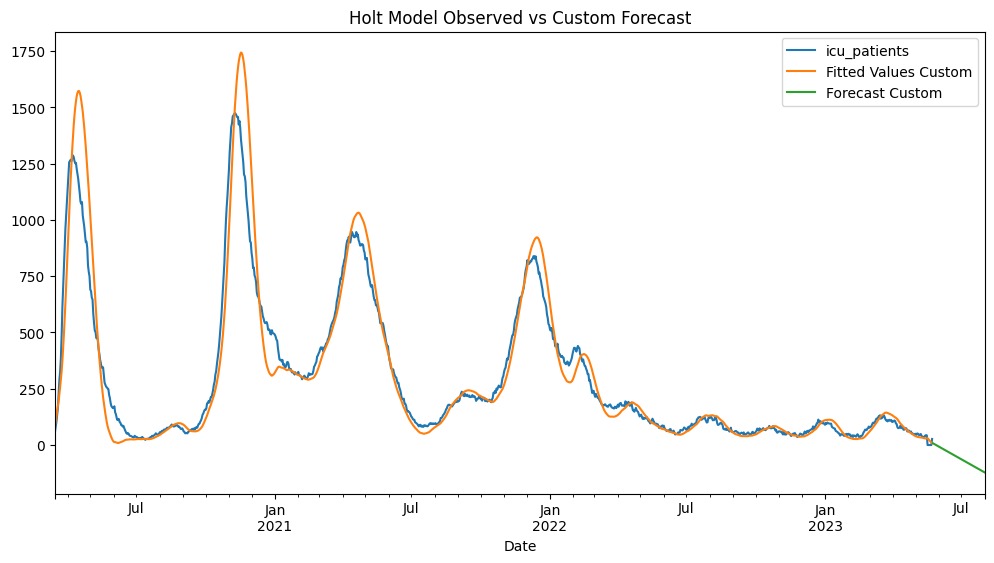

In [30]:
# Let's try to set the parameters ourselves. Recreate the Holt-model with $\alpha = \beta = 0.1$. Calculate a forecast like before and plot.
holt_model_custom = Holt(covid19_be_icu).fit(smoothing_level=0.1, smoothing_trend=0.1)
forecast_icu_custom = holt_model_custom.forecast(70)
forecast_icu_custom.name = 'Forecast Custom'
covid19_be_icu.plot(figsize=(12, 6), title='Holt Model Observed vs Custom Forecast')
holt_model_custom.fittedvalues.plot(label='Fitted Values Custom')
forecast_icu_custom.plot(label='Forecast Custom')
plt.xlabel('Date')
plt.legend()
# The custom forecast with $\alpha = \beta = 0.1$ shows a more gradual increase compared to the default model. This indicates that the model is less responsive to recent changes in the data, resulting in a smoother forecast line.

Compare the model parameters and final estimates. Which of the two forecast models seems to perform best if you look at the plots?

In [31]:
# Compare the model parameters and final estimates. Which of the two forecast models seems to perform best if you look at the plots?
# The default model with automatically calculated parameters seems to perform better as it captures the recent trend more accurately, while the custom model with $\alpha = \beta = 0.1$ is smoother and less responsive to recent changes. The default model's fitted values align more closely with the observed data, indicating a better fit.
# The final estimates for the custom model will also be different due to the fixed parameters. The custom model's final level and trend will be less responsive to recent changes in the data, resulting in a smoother forecast line.
# The custom model's final level and trend will be less responsive to recent changes in the data, resulting in a smoother forecast line.
